In [1]:
import seml
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.dpi'] = 500

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seml/database.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
results = seml.get_results('pbmc_hierarchical', to_data_frame=True)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seml/evaluation.py:80: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


In [3]:
results['result.classification_report.level_1'].iloc[0]

,precision,recall,f1-score,support
B,0.999565,0.999565,0.999565,13800.000000
CD4 T,0.931137,0.936928,0.934024,41001.000000
CD8 T,0.845287,0.707056,0.770017,25469.000000
DC,0.836482,0.999164,0.910615,3589.000000
Mono,0.992297,0.975148,0.983648,49010.000000
NK,0.997577,0.970585,0.983896,18664.000000
other,0.851799,0.859965,0.855862,3442.000000
other T,0.479417,0.799381,0.599370,6789.000000
accuracy,0.915513,0.915513,0.915513,0.915513
macro avg,0.866695,0.905974,0.879625,161764.000000


In [16]:
def extract(
    x,
    t='weighted avg',
    metric='f1-score'
):
    try:
        w = x.loc[t][metric]
    except:
        w = np.nan
    return w
def process_df(df, metric='f1-score'):
    for i in range(1, 4):
        df[f'result.f1-score-weighted.level_{i}'] = df[f'result.classification_report.level_{i}'].apply(
            lambda x: extract(x, metric=metric)
        )
        df[f'result.f1-score-macro.level_{i}'] = df[f'result.classification_report.level_{i}'].apply(
            lambda x: extract(x, 'macro avg', metric=metric)
        )
        df[f'result.accuracy.level_{i}'] = df[f'result.classification_report.level_{i}'].apply(
            lambda x: extract(x, 'accuracy', metric='precision')
        )
        df[f'result.f1-score-weighted_query.level_{i}'] = df[f'result.classification_report_query.level_{i}'].apply(
            lambda x: extract(x, metric=metric)
        )
        df[f'result.f1-score-macro_query.level_{i}'] = df[f'result.classification_report_query.level_{i}'].apply(
            lambda x: extract(x, 'macro avg', metric=metric)
        )
        df[f'result.accuracy_query.level_{i}'] = df[f'result.classification_report_query.level_{i}'].apply(
            lambda x: extract(x, 'accuracy', metric='precision')
        )
    return df

In [6]:
def plot(df, metric):
    df = process_df(df)
    df_scores = df[df.columns[df.columns.str.contains(metric)]]
    df_scores.index = df['config.ann_levels'].astype('str')
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    df_plot = (
        df_scores
        .groupby(
            df_scores.index
        )
        .mean()
        .reindex([
            '[1]',
            '[2]',
            '[3]',
            '[1, 2]',
            '[2, 3]',
            '[1, 2, 3]',
        ])
    )
    df_std = (
        df_scores
        .groupby(
            df_scores.index
        )
        .std()
        .reindex([
            '[1]',
            '[2]',
            '[3]',
            '[1, 2]',
            '[2, 3]',
            '[1, 2, 3]',
        ])
    )
    labels = df_plot.round(2).astype('str') + ' + ' + df_std.round(2).astype('str')
    sns.heatmap(
        df_plot, 
        vmin=0, 
        vmax=1, 
        cmap='viridis', 
        annot=labels.astype('str'),
        fmt='',
        ax=ax
    )
    ax.set_title(metric)
    ax.vlines([2, 4, 6], *ax.get_ylim(), color='black')
    #plt.close()

In [8]:
results = seml.get_results('pbmc_hierarchical', to_data_frame=True)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

<AxesSubplot:>

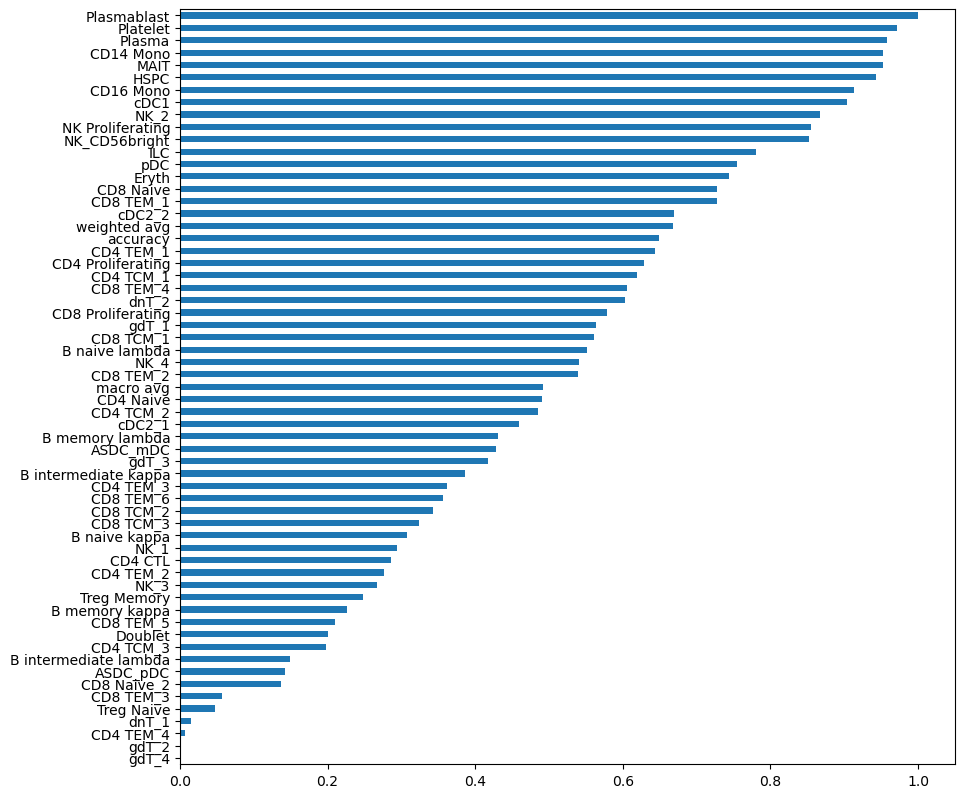

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.rcParams['figure.dpi'] = 100
r = results.iloc[5]['result.classification_report_query.level_3']
r = r['f1-score'][r['support']>0]
(
    r
    .sort_values()
    .plot
    .barh(ax=ax)
)

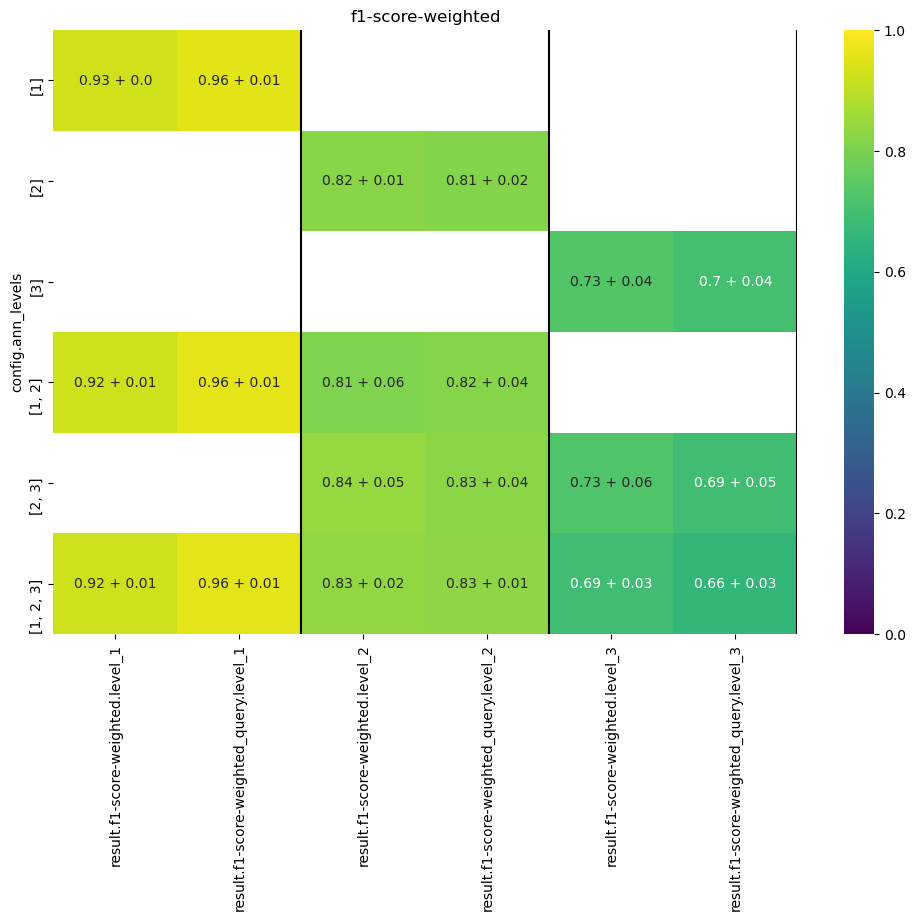

In [17]:
plot(results, 'f1-score-weighted')

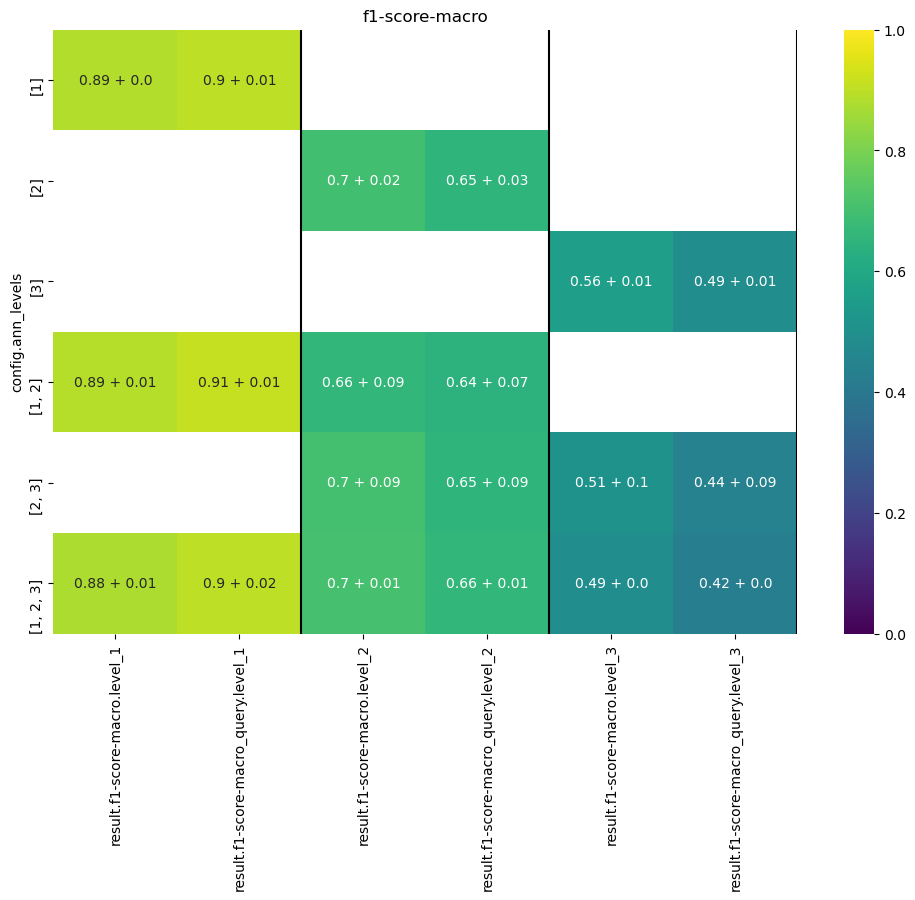

In [18]:
plot(results, 'f1-score-macro')

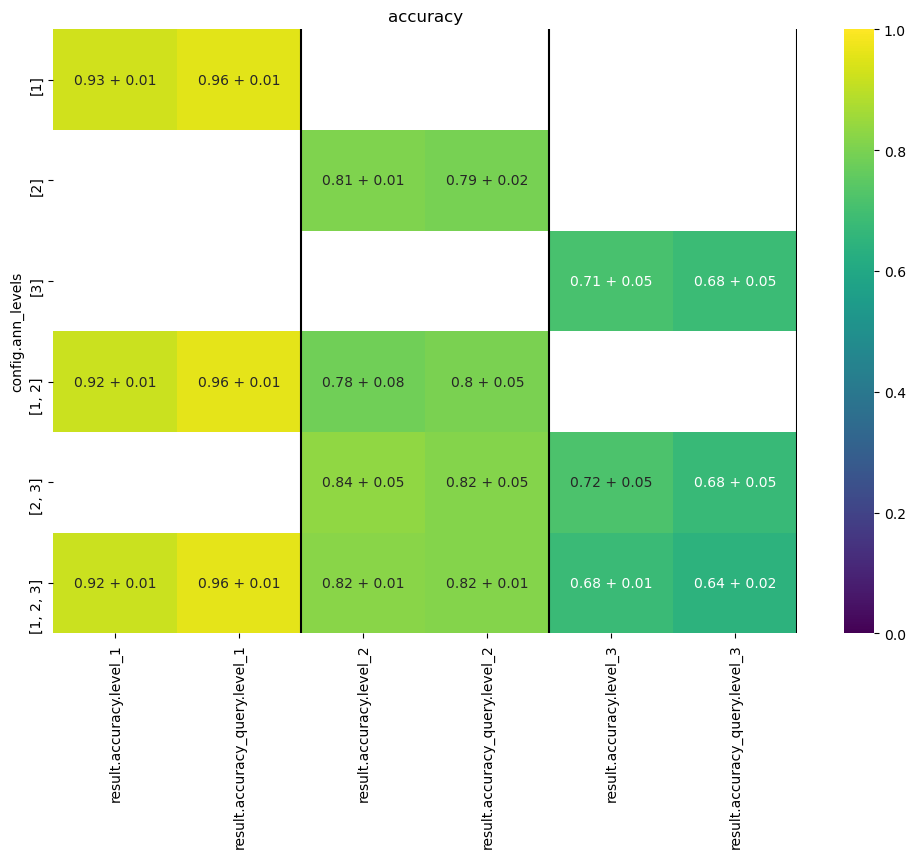

In [19]:
plot(results, 'accuracy')